In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
%matplotlib inline

In [118]:
'''
Wczytywanie pliku tekstowego do DataFrame
filename - nazwa pliku do wczytanie
head - rząd w którym zaczynamy zczytywać dane (licząc od 0), pierwszy rząd to nazwa kolumn w tworzonym DataFrame
'''
def read_file(filename = 'data/zofia_jogurt_kalib_2.txt', head = 8):
    df = pd.read_csv(filename, sep = '\t', header=head, index_col=0)
    try:
        df = df.drop(columns= ['Mic'])
    except KeyError as e:
        pass
    return df

In [119]:
'''
Wyznaczenie punktów do kalibracji
df - dataframe ze współrzędnymi X i Y z EyeTrackera
parts - określa na ile części dzielimy przedział czasowy
first_part - parametr określający ile części przedziału czasowego patrzono na pierwszy punkt
gap - parametr określający ile części przedziału czasowego zajął każdy pomiar
'''
def calc_points(df, parts = 6, first_part = 0.9, gap = 1):
    mid1 = df.iloc[:int(len(df)/parts * first_part), :]
    mid2 = df.iloc[int(len(df)/parts * (first_part + gap * 4 + 0.2)) :, :]
    lgora = df.iloc[int(len(df)/parts * (first_part + 0.2)) : int(len(df)/parts * (first_part + gap)), :]
    pgora = df.iloc[int(len(df)/parts * (first_part + gap + 0.2)) : int(len(df)/parts * (first_part + gap * 2)), :]
    ldol = df.iloc[int(len(df)/parts * (first_part + gap * 2 + 0.2)) : int(len(df)/parts * (first_part + gap * 3)), :]
    pdol = df.iloc[int(len(df)/parts * (first_part + gap * 3 + 0.2)) : int(len(df)/parts * (first_part + gap * 4)), :]

    #DataFrame ze średnimi wartościami dla punktu środkowego (średnia z początku i końca kalibracj)
    mid = mid1.mode().append(mid2.mode()).mean().astype('int')
    #tworzymy DataFrame z punktami do kalibracji (w kolejności: 0 - lewa góra, 1 - prawa góra, 2 - lewy dół, 3 - prawy dół, 4 - środek)
    points = lgora.mode().head(1).append(pgora.mode().head(1)).append(ldol.mode().head(1)).append(pdol.mode().head(1)).append(mid, ignore_index=True) 
    return points

In [204]:
'''
Funkcja rysuje wykres z danych otrzymanych w df (DataFrame), 
na którym znajdują się punkty oznaczające zapisane ruchy gałkek ocznych
oraz wyznaczone punkty kalibracji (czerwone krzyżyki).

Funkcja przyjmuje:
df - DataFrame z danymi do rysowania
filename - nazwa pliku do zapisu wykresu

Funkcja zapisuje wykres w pliku o nazwie "<filename>.png"
'''
def draw_calib_points(df, filename):
    new_filename = filename.split('.')[0] + '.png'
    Eye_X, Eye_Y = (df).Eye_X, (df).Eye_Y
    plt.clf()
    plt.plot(Eye_X, Eye_Y,"o",markersize=1)
    plt.grid(True)
    plt.plot(points.Eye_X, points.Eye_Y,"+r",markersize=20)
    plt.savefig(new_filename)


In [208]:
'''
Funkcja przekazywana do curve_fit,
fitowanie liniowe
'''
def fit(x, a, b):
    return a * x + b


'''
Funkcja rysuje wykres z dopasowaniem prostej do punktów kalibracyjnych.

Funkcja przyjmuje:
df - DataFrame z punktami wykorzystywanymi do kalibracji i odpowiadającymi im wartościami pikseli monitora
a i b - parametry dopasowywanej funkcji liniowej
minumum i maximum - minimum i maximum danych z EyeTrackera (wykorzystywane do policzenia skrajnych wartości na osi X)
filename - nazwa pliku do zapisu wykresu

Funkcja zapisuje wykres w pliku o nazwie "<filename>_liniowa_<nazwa osi>.png"
'''
def draw_calib_linear(df, a, b, minimum, maximum, filename, os):
    xfit = np.linspace(minimum-100, maximum+100, 2000, endpoint=True)
    yfit = fit(xfit, a, b)
    plt.clf()
    plt.plot(xfit, yfit,"o",markersize=1)
    plt.grid(True)
    if os == 'X':
        plt.plot(df.Eye_X, df.x,"+r",markersize=20)
    if os == 'Y':
        plt.plot(df.Eye_Y, df.y,"+r",markersize=20)
        
    new_filename = filename.split('.')[0] + '_liniowa_' + os + '.png'
    plt.savefig(new_filename)


'''
Funkcja rysuje punkty po kalibracji, oznaczające obszar skupienia wzroku na monitorze.

Funkcja przyjmuje:
df - DataFrame z punktami do wyrysowania po kalibracji
filename - nazwa pliku do zapisu wykresu
przedzial - lista punktow oznaczajacych poczatek i koniec rejestracji sygnalu

Funkcja zapisuje wykres w pliku o nazwie "<filename>.png"
''' 
def draw_calibrated(df, filename, przedzial=None):
    if przedzial == None:
        przedzial = [20000, 80000]
    new_filename = filename.split('.')[0] + '.png'
    Eye_X, Eye_Y = df[przedzial[0] : przedzial[1]].Eye_X, df[przedzial[0] : przedzial[1]].Eye_Y * -1
    #Eye_X, Eye_Y = df2.Eye_X, df2.Eye_Y * -1
    plt.clf()
    plt.plot(Eye_X, Eye_Y,"o",markersize=1)
    plt.grid(True)
    plt.savefig(new_filename)

    

'''
Funkcja oblicza parametry kalibracji liniowej
oraz wykorzystując funkcje draw_calib_linear wyrysowuje i zapisuje wykresy z dopasowanymi prostymi do punktów kalibracyjnych. 

Funkcja przyjmuje;
points - DataFrame zawierający punkty wykorzystywane do klaibracji
filename - naz

Zwraca parametry jako tuple:
ax, bx, ay, by - pierwsze dwa to parametry kalibracji do osi X, pozostałe 2 to parametry kalibracji do osi Y
'''
def get_calibration_params(points, filename):
    #Do punktów kalibracyjnych dodajemy spodziewane wartości pikseli na ekranie monitora
    df_pixels = points.copy()
    df_pixels['x'] = pd.Series([0, 1280, 0, 1280, 640])
    df_pixels['y'] = pd.Series([32, 32, 992, 992, 496])
    
    #Obliczenie parametrów funkcji liniowej dla składowej x
    xdata_fit = np.array(df_pixels.Eye_X)
    ydata_fit = np.array(df_pixels.x)
    popt, pcov = curve_fit(fit, xdata_fit, ydata_fit)

    ax, bx = popt
    
    #Obliczenie parametrów funkcji liniowej dla składowej y
    xdata_fit = np.array(df_pixels.Eye_Y)
    ydata_fit = np.array(df_pixels.y)
    popt, pcov = curve_fit(fit, xdata_fit, ydata_fit)

    ay, by = popt
    
    #Wyroysowanie dopasowania na wykresie:
    draw_calib_linear(df_pixels, ax, bx, min(df_pixels.Eye_X),  max(df_pixels.Eye_X), filename, 'X')
    draw_calib_linear(df_pixels, ay, by, min(df_pixels.Eye_Y),  max(df_pixels.Eye_Y), filename, 'Y')

    return ax, bx, ay, by

'''
Funkcja kalibruje zestaw otrzymanych danych w formacie DataFrame,
otrzymujemy zestaw danych który pokazuje gdzie patrzyła badana osoba na monitorze.

Funkcja przyjmuje:
df - DataFrame z danymi pomiarowymi z EyeTrackera do kalibracji
params_tuple = tuple z parametrami dopasowanych funkcji liniowych dla osi X i Y

Funkcja zwraca DataFrame z danymi pomiarowymi po kalibracji
'''
def calibrate_file(df, params_tuple):
    ax, bx, ay, by = params_tuple
    return df * [ax, ay] + [bx, by]


   Eye_X  Eye_Y
0   1725   2975
1   2612   2828
2   1692   2552
3   2820   2157
4   2256   2294


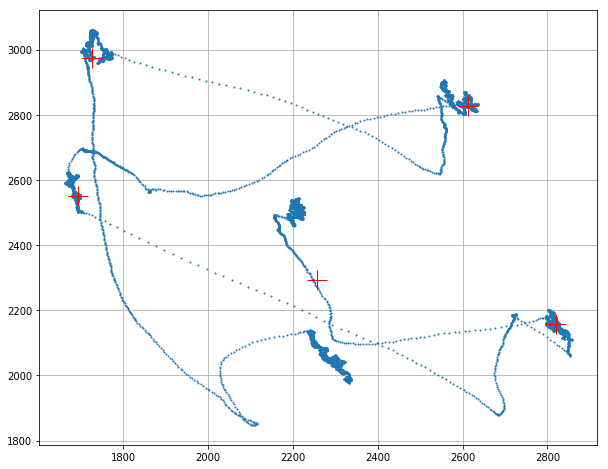

In [209]:
#Wczytanie pliku z danymi do kalibracji
fname = 'data/wojtek_30_04_kalib.txt'
df = read_file(filename=fname)

#Wyznaczanie punktów do kalibracji
points = calc_points(df)
plt.rcParams['figure.figsize'] = [10, 8]
print(points)

#Wyrysowanie i zapisanie wykresu z punktami pomiarowymi w czasie przeprowadzania kalibraci
#oraz z zaznoczonymi punktami, które zostaną wykorzystane do kalibracji.
fname = 'output/' + fname.split('/')[1]
draw_calib_points(df, fname)

(1.241475445818826, -2117.3169651670623, -1.0912982840351704, 3303.8331650708783)


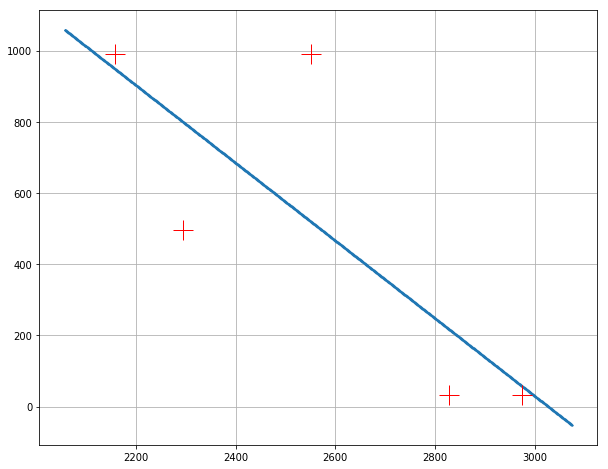

In [211]:
#Obliczanie parametrów funkcji kalibrującej
#oraz iyrysowanie i zapisanie wykresów z dopasowaniem funkcji kalibrującej
fname = 'output/' + fname.split('/')[1]
params = get_calibration_params(points, fname)
print(params)

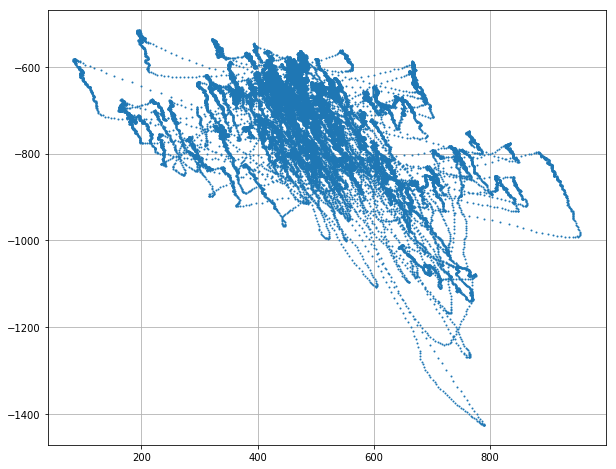

In [212]:
#Wczytanie pliku do kalibrowania (Właściwy plik pomiarowy z przeprowadzonego badania)
fname = 'data/wojtek_film_30_04.txt'
df = read_file(filename=fname)

#Kalibracja danych pomiarowych otrzymanych w eksperymencie
df2 = calibrate_file(df, params)

#Wyrysowanie i zapisanie wykresu z danymi pomiarowymi po kalibracji
#Dane pomiarowe mogą być z pewnogo przedziały czasowego badania
fname = 'output/' + fname.split('/')[1]
draw_calibrated(df2, fname, przedzial = [100000, 160000])